In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download("punkt_tab")
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from datasets import load_dataset

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


## Data Loading

In [6]:
# @title Install dependencies
!pip install pandas --quiet
!pip install --upgrade datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_

### Twitter sentiment analisis *(stanford 140)*

In [7]:
## Here we should read the data from a CSV file or any other source.
# then visualize it using pandas ot matplot to gain insights from it.
# Download dataset from Kaggle and extract/Unzip it.
#!kaggle datasets download -d kazanova/sentiment140

import requests, zipfile, io
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [8]:
import shutil
shutil.rmtree('/root/.cache/huggingface', ignore_errors=True)
!pip install --upgrade datasets fsspec --quiet

In [9]:
# We load the dataset
# We load the dataset
header_list = ["label", "id", "date", "query", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Limit the dataset size
DATASET_SIZE=7000
#df = df[:DATASET_SIZE]

# Show the first few rows
df

,label,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stop_words = set(stopwords.words('english'))
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def preprocess_tweet(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove HTML entities
    text = re.sub(r"&[a-z]+;", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove RT (retweet) headers
    text = re.sub(r"\brt\b", "", text)

    # Replace hashtags with just the word (e.g., "#happy" -> "happy")
    text = re.sub(r"#(\w+)", r"\1", text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Remove stopwords and short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    # Join back to string
    cleaned = " ".join(tokens)
    return cleaned


In [ ]:
tweet = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
cleaned = preprocess_tweet(tweet)
print(cleaned)


that's bummer shoulda got david carr third day ;D


In [ ]:
df["text"][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
df['label'] = df['label'].map(lambda x: 0 if x == 0 else 1 if x == 4 else x)


In [ ]:
df

,label,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


## Visualizing data

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Set the style for seaborn
sns.set(style='whitegrid')
# Set the color palette for seaborn
sns.set_palette('pastel')

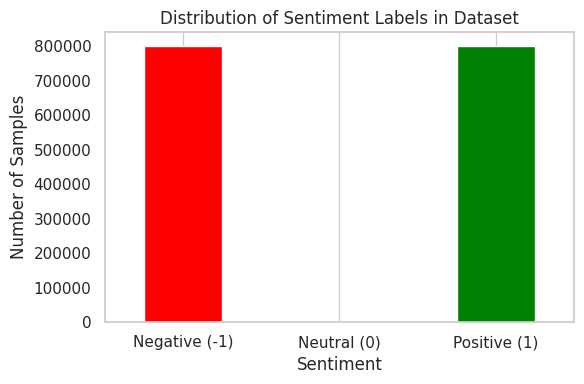

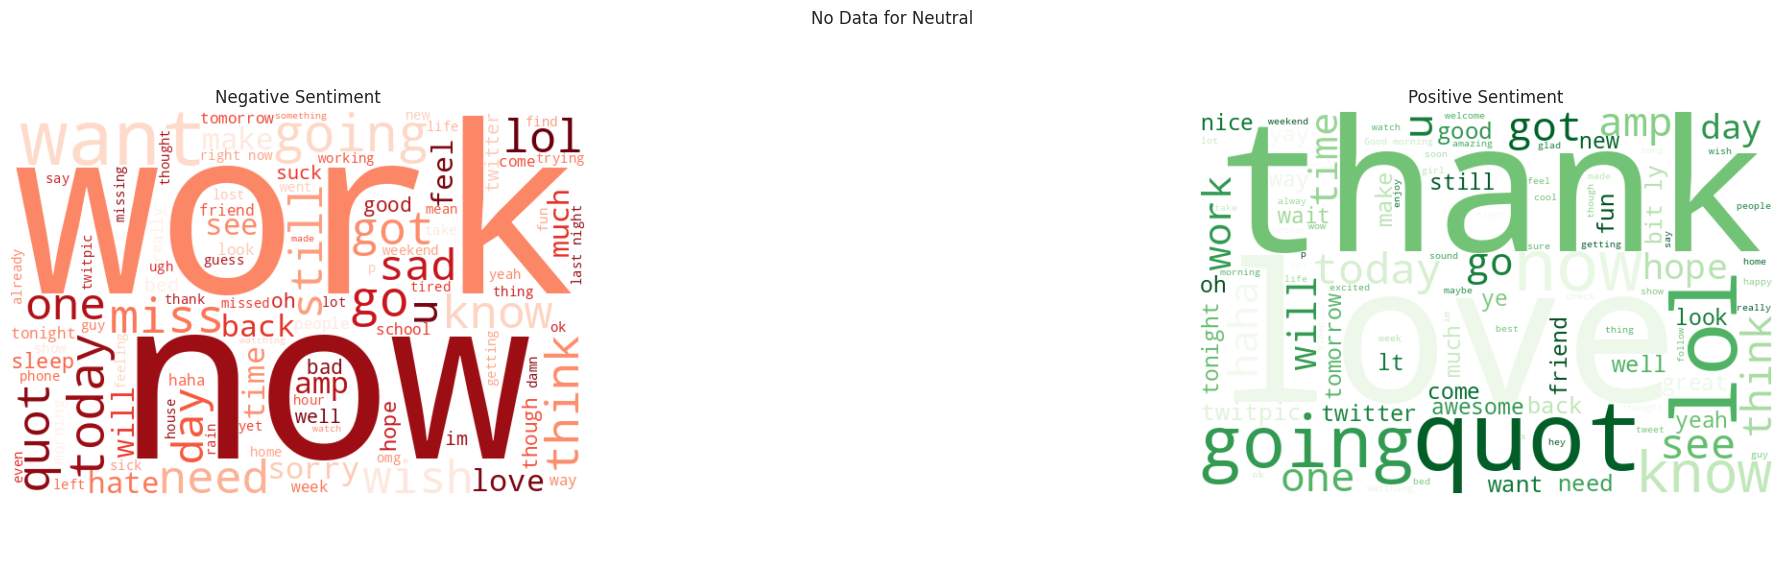

In [ ]:
# Rename sentiment label for clarity (-1: Negative, 0: Neutral, 1: Positive)
df = df.rename(columns={"polarity": "label"})
df["label"] = df["label"].replace({0: -1, 2: 0, 4: 1})  # Adjust if using Twitter sentiment dataset format

# Set visualization style
sns.set(style="whitegrid", palette="pastel")

# --- Visualization 1: Sentiment Label Distribution ---
plt.figure(figsize=(6, 4))
expected_labels = [-1, 0, 1]
label_counts = df["label"].value_counts().reindex(expected_labels, fill_value=0)
label_counts.plot(kind="bar", color=["red", "gray", "green"])
plt.title("Distribution of Sentiment Labels in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Number of Samples")
plt.xticks(ticks=[0, 1, 2], labels=["Negative (-1)", "Neutral (0)", "Positive (1)"], rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# --- Visualization 2: Word Clouds per Sentiment Class ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sentiments = {-1: "Negative", 0: "Neutral", 1: "Positive"}
colors = {-1: "Reds", 0: "Greys", 1: "Greens"}

for idx, sentiment in enumerate(sentiments.keys()):
    texts = df[df["label"] == sentiment]["text"].dropna().astype(str)
    combined_text = " ".join(texts)
    if combined_text.strip():
        wordcloud = WordCloud(width=600, height=400, background_color="white",
                              colormap=colors[sentiment], max_words=100).generate(combined_text)
        axes[idx].imshow(wordcloud, interpolation="bilinear")
        axes[idx].set_title(f"{sentiments[sentiment]} Sentiment")
        axes[idx].axis("off")
    else:
        axes[idx].set_title(f"No Data for {sentiments[sentiment]}")
        axes[idx].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_ratio=0.8, eval_ratio=0.1, test_ratio=0.1, seed=42):
    assert abs(train_ratio + eval_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

    # First split: train and temp (eval + test)
    train_data, temp_data = train_test_split(dataset, test_size=(1 - train_ratio), random_state=seed)

    # Split temp into eval and test
    eval_size = eval_ratio / (eval_ratio + test_ratio)
    eval_data, test_data = train_test_split(temp_data, test_size=(1 - eval_size), random_state=seed)

    return train_data, eval_data, test_data




```
# This is formatted as code
```

## Preprocessing Part

In [ ]:
from datasets import Dataset

# Convert DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# Shuffle the dataset with a fixed seed
dataset = dataset.shuffle(seed=42)
df = dataset.select(range(100000))


In [ ]:
# dataset

In [ ]:
from collections import Counter

print(Counter(df['label']))


Counter({-1: 50262, 1: 49738})


In [ ]:
def preprocess_tweet_example(example):
    example["text"] = preprocess_tweet(example["text"])
    return example

df = df.map(preprocess_tweet_example)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [ ]:
for lin in range(10):

    print(df["text"][lin])

awake early damn projects super nervous science one mines gunna lame dont wanna fail
watching church online half hour late time got
hillsong
stafford train station watched em's train pull away heading southbound wcml
thanks everyone follow fridays
waffle house like 5am proceeded drop living room rug grits hard clean drunk
afternoon going see hannah montana movie like hair ..
watched news look great gold printed maxi dress wonder shoes wearing
fly beautiful love
finished sarah bayla's first birthday party


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

class TweetPreprocessor:
    def init(self, remove_stopwords=True, lemmatize=True, correct_spelling=True):
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.correct_spelling = correct_spelling
        self.punctuation_table = str.maketrans('', '', string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def clean_tweet(self, text: str) -> str:
        # Lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)

        # Remove punctuation
        text = text.translate(self.punctuation_table)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        # Lemmatize
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # Rejoin
        return " ".join(tokens)

    def clean_corpus(self, texts: list) -> list:
        return [self.clean_tweet(text) for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#preprocessor = TweetPreprocessor()
#train_dataset["text"] = preprocessor.clean_corpus(train_dataset["text"])

def preprocess_batch(batch):
    batch["text"] = preprocessor.clean_corpus(batch["text"])
    return batch
df_preprocessed = df.map(preprocess_batch, batched=True)


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
dataset_preprocessed.to_pandas().to_csv("dataset_twitter_preproc.csv", index=False)

from google.colab import files
files.download('dataset_twitter_preproc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Unfrozen Encoder for Training and Validating in Context A**

In [21]:
## Load data

import os
print(os.getcwd())

from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir('/content/drive/MyDrive'))

df = pd.read_csv('/content/drive/MyDrive/Dataset/df_preprocessed_twitter.csv')

# subset the dataframe to only use "label" and "text":
dataset_A = df[["label", "text"]].copy()

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Screenshot_20250514-174046_WhatsApp.jpg', 'DOC-20190309-WA0018 (1).gdoc', 'DOC-20190309-WA0018.gdoc', '408607204 (1).pdf', 'بدون اسم1_20200603065629 (1).png', 'بدون اسم1_20200603065629.png', 'بدون اسم1.ipv', 'بدون اسم2.jpg', 'بدون اسم1.png', '408607204.pdf', 'Untitled6.png', 'Untitled10.png', 'Untitled21.png', 'Untitled24.png', 'Untitled26.png', 'Untitled29.png', 'Untitled30.png', 'Untitled31.png', 'Untitled presentation.gslides', 'Untitled23 (1).png', 'jaina.png', 'images(3).jpg', 'Untitled23.png', 'SPACE.png', 'calories-pdf.pdf', 'accounts.txt', 'Untitled spreadsheet (1).gsheet', 'Mo3b7amed .gdoc', 'Accounts.gdoc', 'بدون اسم49.png', 'بدون اسم50.png', 'بدون اسم51.png', 'William vangance fan art2.png', 'بدون اسم51_20210322002432.png', 'The_Prisoner_of_Zenda_by_Anthony_Hope.epub', 'مقال كلية اداب.rtf', 'Untitled.gdoc', 'مقال اداب.pdf', 'Descriptive 

In [24]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset # Import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

# Define your existing Dataset class here
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = str(self.dataframe.iloc[index]['text'])
        label = self.dataframe.iloc[index]['label']

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Load MiniBERT model and tokenizer
model_name = "prajjwal1/bert-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)

# Split Dataset A (your original dataset)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    dataset_A['text'],  # Replace with your actual dataset A
    dataset_A['label'],
    test_size=0.2,
    random_state=42
)

train_df_A = pd.DataFrame({'text': X_train_A, 'label': y_train_A})
test_df_A = pd.DataFrame({'text': X_test_A, 'label': y_test_A})

# Create datasets and loaders for Dataset A
train_dataset_A = IMDBDataset(train_df_A, tokenizer)  # Use your existing dataset class
test_dataset_A = IMDBDataset(test_df_A, tokenizer)

batch_size = 64
train_loader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
test_loader_A = DataLoader(test_dataset_A, batch_size=batch_size, shuffle=False)

# IMPORTANT: DO NOT freeze encoder for Dataset A - we want to fine-tune it
# for param in encoder.parameters():  # DON'T DO THIS for Dataset A
#     param.requires_grad = False

# Define classifier model
class MiniBERTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(MiniBERTClassifier, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Create model for Dataset A
num_classes_A = 2  # Adjust based on your Dataset A
model_A = MiniBERTClassifier(encoder=encoder, num_classes=num_classes_A)

# Setup training for Dataset A
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_A = model_A.to(device)

# Use normal learning rate for fine-tuning
optimizer_A = torch.optim.Adam(model_A.parameters(), lr=2e-5)  # Standard fine-tuning LR
criterion = torch.nn.CrossEntropyLoss()


In [25]:
print("=== PHASE 1: Fine-tuning on Dataset A ===")
print("All parameters (including encoder) are trainable")

# Check trainable parameters
trainable_params = sum(p.numel() for p in model_A.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_A.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

# Training loop for Dataset A
train_losses_A = []
train_accuracies_A = []
test_accuracies_A = []
num_epochs = 5

for epoch in range(num_epochs):
    model_A.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader_A:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer_A.zero_grad()
        outputs = model_A(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_A.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader_A)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses_A.append(avg_loss)
    train_accuracies_A.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # Evaluation on test set A
    model_A.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader_A:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model_A(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies_A.append(test_acc)
    print(f"→ Test Accuracy: {test_acc:.4f}")

# Save the fine-tuned model from Dataset A
print("Saving fine-tuned model from Dataset A...")
torch.save(model_A.state_dict(), '/content/drive/MyDrive/finetuned_model_A.pth')
print("Model A saved!")

=== PHASE 1: Fine-tuning on Dataset A ===
All parameters (including encoder) are trainable
Trainable parameters: 11,171,074 / 11,171,074


KeyboardInterrupt: 

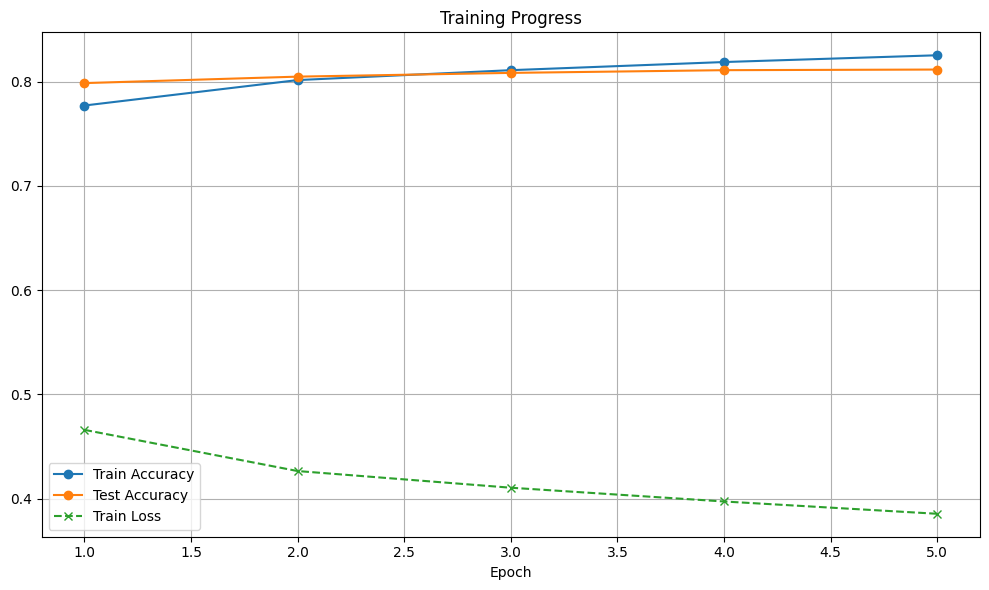

In [27]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_losses_A = [0.4661, 0.4266, 0.4106, 0.3974, 0.3856]
train_accuracies_A = [0.7771, 0.8015, 0.8110, 0.8188, 0.8253]
test_accuracies_A = [0.7986, 0.8048, 0.8084, 0.8110, 0.8116]

plt.figure(figsize=(10, 6))

# Plot accuracies
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')

# Plot loss (separate axis or scale optional)
plt.plot(epochs, train_losses, label='Train Loss', marker='x', linestyle='--')

plt.xlabel('Epoch')
plt.title('Training Progress')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


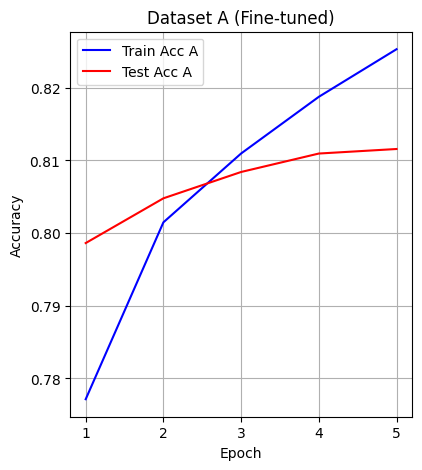

In [ ]:
# Plot comparison
plt.figure(figsize=(15, 5))

# Dataset A results
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_A, 'b-', label='Train Acc A')
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'r-', label='Test Acc A')
plt.title('Dataset A (Fine-tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

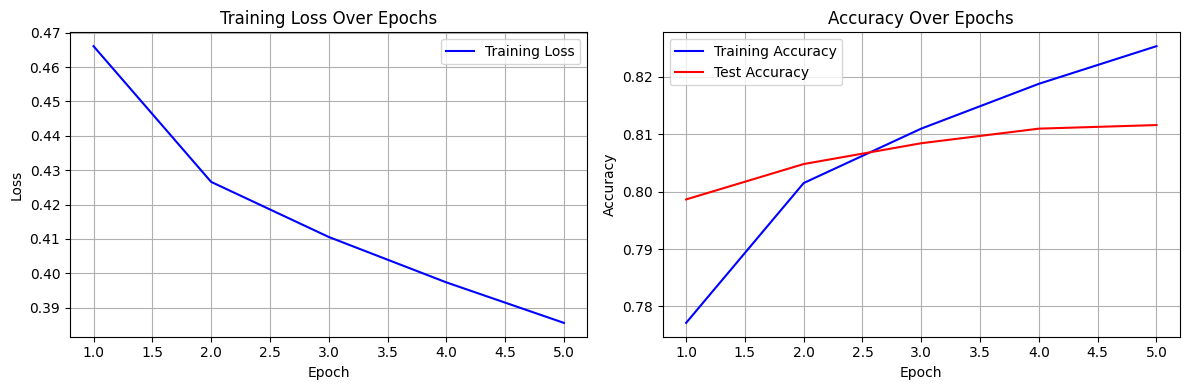

In [ ]:
# Plot the results
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses_A, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies_A, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'r-', label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Phase 2: Transfer Learning to Dataset B**

In [11]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/df_preprocessed_movies_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/df_preprocessed_movies_test.csv')

# Combine the datasets
df_contextB = pd.concat([train_df, test_df], ignore_index=True)

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print(f"Combined dataset shape: {df_contextB.shape}")

# Display first few rows
print("\nFirst 5 rows of combined dataset:")
print(df_contextB.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset shape: (25000, 2)
Test dataset shape: (122, 2)
Combined dataset shape: (25122, 2)

First 5 rows of combined dataset:
                                                text  label
0  probably best movie filmed least last five yea...      1
1  small town kid working big city becomes huge s...      1
2  moved young life experience man rose high acad...      1
3  barney imagination guy preschooler never wante...      1
4  night demon great movie excellent example good...      1


In [12]:
# Map -1 to 0, 1 stays 1 for all of df_contextB
df_contextB['label'] = df_contextB['label'].map({-1: 0, 1: 1})

# Replace NaN labels with 0
df_contextB['label'] = df_contextB['label'].fillna(0)

# Double-check
print(df_contextB['label'].isnull().sum())  # Should print 0
print(df_contextB['label'].unique())        # Should print only 0 and 1

0
[1. 0.]


In [13]:
print("Unique labels in train:", df_contextB['label'].unique())

Unique labels in train: [1. 0.]


In [14]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset # Import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

# Define the ContextBDataset class
class ContextBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = str(self.dataframe.iloc[index]['text'])
        label = self.dataframe.iloc[index]['label']

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [16]:
print(df_contextB['label'].unique())
print(df_contextB['label'].isnull().sum())

[1. 0.]
0


In [15]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset # Import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

class MiniBERTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(MiniBERTClassifier, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
print("\n=== PHASE 2: Transfer Learning to Dataset B ===")

batch_size = 64
num_classes_A = 2
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()

# Load Dataset B
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    df_contextB['text'],  # Your Dataset B
    df_contextB['label'],
    test_size=0.2,
    random_state=42
)

train_df_B = pd.DataFrame({'text': X_train_B, 'label': y_train_B})
test_df_B = pd.DataFrame({'text': X_test_B, 'label': y_test_B})

# Load MiniBERT model and tokenizer
model_name = "prajjwal1/bert-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)

# Create datasets and loaders for Dataset B
train_dataset_B = ContextBDataset(train_df_B, tokenizer)  # Changed from IMDBDataset
test_dataset_B = ContextBDataset(test_df_B, tokenizer)    # Changed from IMDBDataset

train_loader_B = DataLoader(train_dataset_B, batch_size=batch_size, shuffle=True)
test_loader_B = DataLoader(test_dataset_B, batch_size=batch_size, shuffle=False)

# Create new model for Dataset B (different number of classes if needed)
num_classes_B = 2  # Adjust based on your Dataset B
encoder_B = AutoModel.from_pretrained(model_name)  # Fresh encoder

# Load the fine-tuned weights from Dataset A
model_B = MiniBERTClassifier(encoder=encoder, num_classes=num_classes_A)
model_B.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/finetuned_model_A.pth', map_location=device))

# Replace classifier head if different number of classes
if num_classes_B != num_classes_A:
    model_B.classifier = nn.Linear(model_B.encoder.config.hidden_size, num_classes_B)
    torch.nn.init.xavier_uniform_(model_B.classifier.weight)
    model_B.classifier.bias.data.fill_(0.01)

# NOW freeze the encoder for transfer learning
print("Freezing encoder for transfer learning...")
for param in model_B.encoder.parameters():
    param.requires_grad = False

# Only classifier parameters should be trainable
for param in model_B.classifier.parameters():
    param.requires_grad = True

model_B = model_B.to(device)

# Check trainable parameters
trainable_params = sum(p.numel() for p in model_B.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_B.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")
print("Only classifier head is trainable")

# Use lower learning rate for transfer learning
optimizer_B = torch.optim.Adam(filter(lambda p: p.requires_grad, model_B.parameters()), lr=1e-4)

# Training loop for Dataset B (transfer learning)
train_losses_B = []
train_accuracies_B = []
test_accuracies_B = []

for epoch in range(num_epochs):
    model_B.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader_B:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer_B.zero_grad()
        outputs = model_B(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_B.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader_B)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses_B.append(avg_loss)
    train_accuracies_B.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # Evaluation on test set B
    model_B.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader_B:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model_B(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies_B.append(test_acc)
    print(f"→ Test Accuracy: {test_acc:.4f}")

# Save transfer learning model
torch.save(model_B.state_dict(), '/content/drive/MyDrive/transfer_learning_model_B.pth')
print("Transfer learning model saved!")


=== PHASE 2: Transfer Learning to Dataset B ===
Freezing encoder for transfer learning...
Trainable parameters: 514 / 11,171,074
Only classifier head is trainable
Epoch 1/5 | Train Loss: 0.5689 | Train Accuracy: 0.7083
→ Test Accuracy: 0.7021
Epoch 2/5 | Train Loss: 0.5612 | Train Accuracy: 0.7105
→ Test Accuracy: 0.7061
Epoch 3/5 | Train Loss: 0.5560 | Train Accuracy: 0.7136
→ Test Accuracy: 0.7095
Epoch 4/5 | Train Loss: 0.5541 | Train Accuracy: 0.7165
→ Test Accuracy: 0.7120
Epoch 5/5 | Train Loss: 0.5503 | Train Accuracy: 0.7173
→ Test Accuracy: 0.7140
Transfer learning model saved!


# **Compare Results**

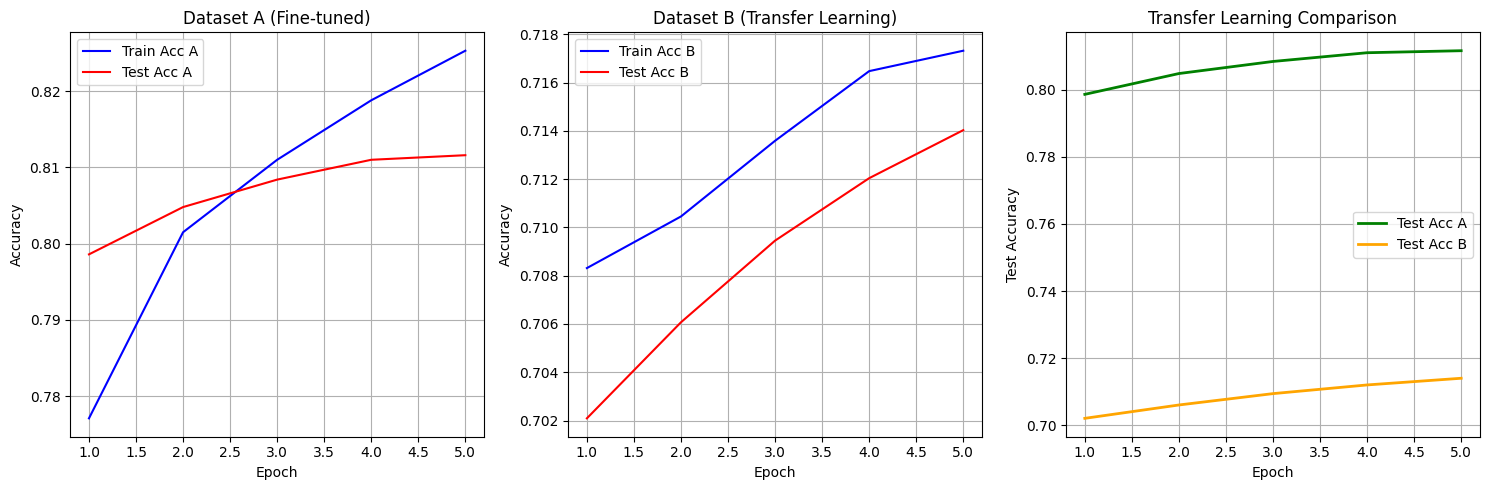

Final Test Accuracy on Dataset A: 0.8116
Final Test Accuracy on Dataset B: 0.7140


In [28]:
# Plot comparison
plt.figure(figsize=(15, 5))

# Dataset A results
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_A, 'b-', label='Train Acc A')
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'r-', label='Test Acc A')
plt.title('Dataset A (Fine-tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Dataset B results
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies_B, 'b-', label='Train Acc B')
plt.plot(range(1, num_epochs + 1), test_accuracies_B, 'r-', label='Test Acc B')
plt.title('Dataset B (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'g-', label='Test Acc A', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_accuracies_B, 'orange', label='Test Acc B', linewidth=2)
plt.title('Transfer Learning Comparison')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy on Dataset A: {test_accuracies_A[-1]:.4f}")
print(f"Final Test Accuracy on Dataset B: {test_accuracies_B[-1]:.4f}")

# **This Code Below is for using a pretrained model with fixed encoders**

## Training and Validating in Context A

In [ ]:
# some clarification on terminology:

## train set: This is the data your model actually learns from. During training, the model adjusts its parameters to fit this data.

## validation set: This is used to tune your model’s hyperparameters (like learning rate, number of layers, etc.) and to check how well your model is generalizing during training.
### we use the validation set to: Monitor for overfitting (when your model memorizes the train data but doesn’t generalize well) Select the best model or best hyperparameters

# test set: This is used only once, after all training and tuning is done.
# It gives you an unbiased estimate of how your model will perform on completely new, unseen data.
# this is were we look into the transfer learning


Step 1: Load Data

In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive'))

['codespace-2.2_ngj.ipynb', 'CG01_Data', 'CG01_StudySetup', 'CG01_Gearshift1', 'CG01_Madeline', 'df_preprocessed_twitter.csv']


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df_preprocessed_twitter.csv')

# subset the dataframe to only use "label" and "text":
df = df[["label", "text"]].copy()

In [ ]:
df

,label,text
0,0,awake early damn project super nervous science...
1,0,watching church online id half hour late time got
2,1,hillsong
3,0,stafford train station watched em train pull a...
4,1,thanks everyone follow friday
...,...,...
1599995,0,magic playing second final game social chapero...
1599996,0,wish something good happen
1599997,1,soundlyawake mornin chicken
1599998,1,listening mia rose touch soul


Step 2: Preprocess by splitting data into test and train sets

In [ ]:
# split into test and train dataset

from sklearn.model_selection import train_test_split

#X_train, X_test = train_test_split(df, test_size=0.2, random_state=42) # Split into 80% train, 20% test

# Save as CSV files
X_train.to_csv('/content/drive/MyDrive/df_preprocessed_twitter_train_ngj.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/df_preprocessed_twitter_test_ngj.csv', index=False)

print("Files saved successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Files saved successfully!
X_train shape: (1280000, 2)
X_test shape: (320000, 2)


Step 3: Create PyTorch Dataset and DataLoader

In [ ]:
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer

# Create a custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = str(self.dataframe.iloc[index]['text'])
        label = self.dataframe.iloc[index]['label']

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

batch_size = 64

# Define the tokenizer
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")



Step 4: Model Setup

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Load MiniBERT model and tokenizer (MiniBERT is often based on "prajjwal1/bert-mini")
model_name = "prajjwal1/bert-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)  # Only gets the encoder

# Create Dataset instances
train_dataset = IMDBDataset(X_train, tokenizer)
test_dataset = IMDBDataset(X_test, tokenizer)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Freeze all encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

# Define your classifier model
class MiniBERTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(MiniBERTClassifier, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Only use the pooled output (representation of [CLS] token)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Example usage
model = MiniBERTClassifier(encoder=encoder, num_classes=2)
# inputs = tokenizer("Example sentence", return_tensors="pt")
# logits = model(**inputs)


# Should print only classifier parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name} -> {param.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Trainable: classifier.weight -> torch.Size([2, 256])
Trainable: classifier.bias -> torch.Size([2])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Confirm only classifier parameters will be updated

## note that lr is the learning rate for this training section (important for transfer learning where it needs to be set to a lower level)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print(f"Using device: {device}")

# move from cpu to gpu usage

Using device: cuda


Step 5: Train the model and save outputs

Epoch 1/5 | Train Loss: 12680.0701 | Train Accuracy: 0.6381
→ Test Accuracy: 0.6737
Epoch 2/5 | Train Loss: 12677.4047 | Train Accuracy: 0.6386
→ Test Accuracy: 0.6714
Epoch 3/5 | Train Loss: 12674.7199 | Train Accuracy: 0.6388
→ Test Accuracy: 0.6748
Epoch 4/5 | Train Loss: 12673.1292 | Train Accuracy: 0.6388
→ Test Accuracy: 0.6733
Epoch 5/5 | Train Loss: 12666.0688 | Train Accuracy: 0.6391
→ Test Accuracy: 0.6700


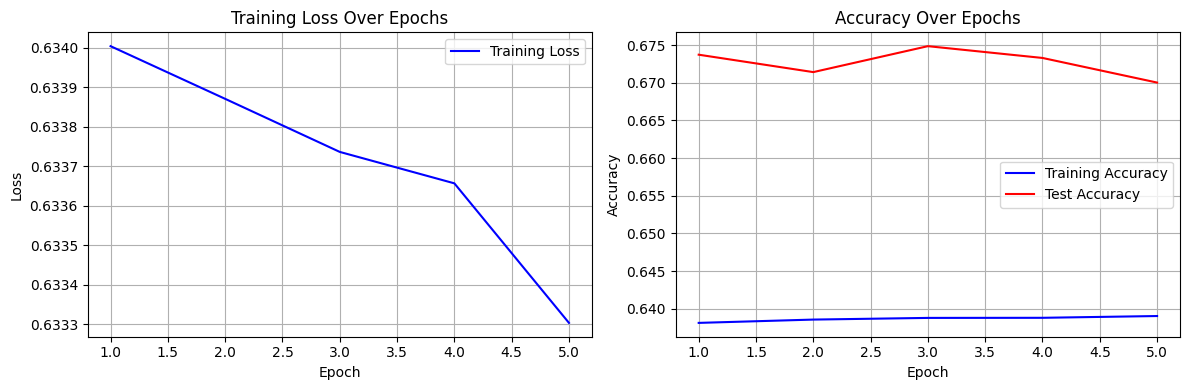

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # calculate the metrics
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    # store metrics
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Train Accuracy: {acc:.4f}")

    # Evaluation on test set
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies.append(test_acc)
    print(f"→ Test Accuracy: {test_acc:.4f}")

# Plot the results
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Message when done
print("Training completed. Saving model...")
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved as 'trained_model.pth'")

# Optional: Save training metrics too
import pickle
metrics = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies
}
with open('training_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
# save the plots
plt.savefig('training_metrics.png')  # Saves the figure as a PNG file
plt.show()

from google.colab import files
files.download('training_metrics.png')

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
## save model outputs

import os
print(os.getcwd())

# Save the model
torch.save(model.state_dict(), 'my_model.pth')

# Load the model later
model.load_state_dict(torch.load('my_model.pth'))
model.eval()  # Set to evaluation mode


/content


MiniBERTClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, eleme

In [ ]:
# Save model with training info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': avg_loss,
    'accuracy': train_acc
}
torch.save(checkpoint, 'model_checkpoint.pth')

# Load checkpoint
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

###########################################################

Marwan Section

###########################################################

In [ ]:
extended_tokenizer= AutoTokenizer.from_pretrained("/content/drive/MyDrive/Tokenizer-1 extended")

########################################################################
## Transfer Learning Section
########################################################################

Key Tansfer Learning Strategies:

Step 1: Feature extraction (freeze backbone)
- Freeze all layers except final classifier
- Fast training, good for small datasets

Step 2: Fine-tuning (unfreeze some/all layers):

In [29]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/df_preprocessed_movies_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/df_preprocessed_movies_test.csv')

# Combine the datasets
df_contextB = pd.concat([train_df, test_df], ignore_index=True)

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")
print(f"Combined dataset shape: {df_contextB.shape}")

# Display first few rows
print("\nFirst 5 rows of combined dataset:")
print(df_contextB.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train dataset shape: (25000, 2)
Test dataset shape: (122, 2)
Combined dataset shape: (25122, 2)

First 5 rows of combined dataset:
                                                text  label
0  probably best movie filmed least last five yea...      1
1  small town kid working big city becomes huge s...      1
2  moved young life experience man rose high acad...      1
3  barney imagination guy preschooler never wante...      1
4  night demon great movie excellent example good...      1


In [30]:
# Preprocess df_contextB (split into features and labels and train and test sets)

from sklearn.model_selection import train_test_split

# Suppose your label column is called 'label'
X = df_contextB['text']  # or whatever your feature column is
y = df_contextB['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 3: Create PyTorch Dataset and DataLoader

In [34]:
# Create PyTorch Dataset and DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer

# 1. Split your new dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_contextB['text'],  # Adjust column name if different
    df_contextB['label'], # Adjust column name if different
    test_size=0.2,
    random_state=42
)

# Recreate dataframes for the Dataset class
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# 2. Reuse your existing Dataset class (just rename it)
class ContextBDataset(Dataset):  # Renamed from IMDBDataset
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = str(self.dataframe.iloc[index]['text'])
        # Ensure label is treated as an integer/long
        label = int(self.dataframe.iloc[index]['label'].item())


        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 3. Create tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 64

train_dataset = ContextBDataset(train_df, tokenizer)
test_dataset = ContextBDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 20097
Test dataset size: 5025


Step 4: Model Setup

In [32]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch

# Load MiniBERT model and tokenizer (MiniBERT is often based on "prajjwal1/bert-mini")
model_name = "prajjwal1/bert-mini"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder = AutoModel.from_pretrained(model_name)  # Only gets the encoder

# Create Dataset instances
train_dfB = IMDBDataset(X_train, tokenizer)
test_dfB = IMDBDataset(X_test, tokenizer)

# Create DataLoader instances
train_loader = DataLoader(train_dfB, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dfB, batch_size=batch_size, shuffle=False)

# Freeze all encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

# Define your classifier model
class MiniBERTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(MiniBERTClassifier, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Only use the pooled output (representation of [CLS] token)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token representation
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Create model instance
num_classes = 2  # Adjust based on your df_contextB labels
model = MiniBERTClassifier(encoder=encoder, num_classes=num_classes)


# Check trainable parameters
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name} -> {param.shape}")

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Trainable parameters:
Trainable: classifier.weight -> torch.Size([2, 256])
Trainable: classifier.bias -> torch.Size([2])

Train dataset size: 20097
Test dataset size: 5025


Step 5: Model Training

Starting transfer learning training...
Device: cuda
Learning rate: 0.0001
Epoch 1/5 | Train Loss: 0.7231 | Train Accuracy: 0.5154
→ Test Accuracy: 0.6312
Epoch 2/5 | Train Loss: 0.6702 | Train Accuracy: 0.5942
→ Test Accuracy: 0.6969
Epoch 3/5 | Train Loss: 0.6388 | Train Accuracy: 0.6321
→ Test Accuracy: 0.7118
Epoch 4/5 | Train Loss: 0.6218 | Train Accuracy: 0.6581
→ Test Accuracy: 0.7210
Epoch 5/5 | Train Loss: 0.6073 | Train Accuracy: 0.6740
→ Test Accuracy: 0.7270


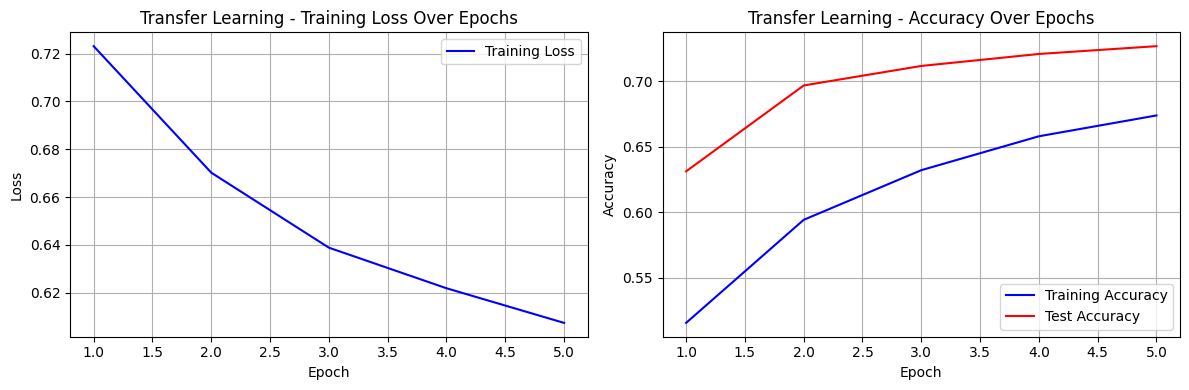

Transfer learning completed. Saving model...
Transfer learning model saved as 'transfer_learning_model.pth'
Training metrics saved!
Final Test Accuracy: 0.7270


In [35]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import pickle

# Setup device, optimizer, and loss function for transfer learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Use lower learning rate for transfer learning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for transfer learning
criterion = torch.nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 5

print("Starting transfer learning training...")
print(f"Device: {device}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate the metrics
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)

    # Store metrics
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    # Evaluation on test set
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies.append(test_acc)
    print(f"→ Test Accuracy: {test_acc:.4f}")

# Plot the results
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.title('Transfer Learning - Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.title('Transfer Learning - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the transfer learning model
print("Transfer learning completed. Saving model...")
torch.save(model.state_dict(), '/content/drive/MyDrive/transfer_learning_model.pth')
print("Transfer learning model saved as 'transfer_learning_model.pth'")

# Save training metrics
metrics = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies
}
with open('/content/drive/MyDrive/transfer_learning_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print("Training metrics saved!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

In [ ]:
## Optional
# 1. Load your trained model (assuming you saved it)
# model.load_state_dict(torch.load('your_model.pth'))

In [36]:
# make sure to use a lower learning rate for transfer learning (lower than what was used above)
# num_new_classes: the number of classifications in the new dataset

def setup_transfer_learning(model, num_new_classes, freeze_backbone=True, lr=1e-4):
    """Setup model for transfer learning"""

    # Replace final classification layer
    if hasattr(model, 'classifier'):
        in_features = model.classifier.in_features
        model.classifier = torch.nn.Linear(in_features, num_new_classes)
        final_layer = model.classifier
    elif hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = torch.nn.Linear(in_features, num_new_classes)
        final_layer = model.fc

    # 3. Freeze earlier layers (for feature extraction)
    if freeze_backbone:
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze final layer
        for param in final_layer.parameters():
            param.requires_grad = True

    # Setup optimizer with lower learning rate
    ## Use a lower learning rate for transfer learning
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    return model, optimizer

# Usage:
num_new_classes = 2  # Your new dataset's number of classes
model, optimizer = setup_transfer_learning(model, num_new_classes, freeze_backbone=True)

# Move to device
model = model.to(device)


# Use same training loop with new data loaders
# load twitter data and run transfer learning on them


In [ ]:
# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use very low learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
########################################################################
## Section B: Training an own tokenizer - Tony's code
########################################################################

In [ ]:
import pandas as pd

# Load your dataset
# df = pd.read_csv("dataset.csv")  # adjust this to your file
texts = X_train['text'].astype(str).tolist()

# Save as a text file
with open("corpus.txt", "w", encoding="utf-8") as f:
    for line in texts:
        f.write(line.strip() + "\n")

In [ ]:
from tokenizers import BertWordPieceTokenizer
import os

# Initialize a WordPiece tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=True,
    lowercase=True,
    strip_accents=True
)

# Train the tokenizer
tokenizer.train(
    files=["corpus.txt"],
    vocab_size=30522,  # standard BERT vocab size
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Create the directory if it doesn't exist
output_dir = "custom_tokenizer/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the tokenizer
tokenizer.save_model(output_dir)

In [ ]:
from transformers import AutoModel, BertTokenizerFast
import torch.nn as nn
import torch

# Load custom tokenizer
tokenizer = BertTokenizerFast.from_pretrained("custom_tokenizer/")

# Load pretrained MiniBERT encoder
model_name = "prajjwal1/bert-mini"
encoder = AutoModel.from_pretrained(model_name)

# Resize embedding layer to match custom tokenizer
encoder.resize_token_embeddings(len(tokenizer))

# Freeze encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

# Define classifier wrapper
class MiniBERTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(MiniBERTClassifier, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Create model instance
model = MiniBERTClassifier(encoder=encoder, num_classes=2)

# Confirm trainable params
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name} -> {param.shape}")


In [ ]:
#########################################
### Ignore the code below because this is nadja's code and we use the code above

In [ ]:
########################################################################
## Section B: Training an own tokenizer
########################################################################

In [ ]:
# Step 1: select text data for each tokenizer
movie_texts = movie_df['text'].tolist()
twitter_texts = twitter_df['text'].tolist()
combined_texts = movie_texts + twitter_texts

In [ ]:
# Step 2: train a tokenizer from scratch
from tokenizers import BertWordPieceTokenizer

########
## params description:
# vocab_size: 30522 matches BERT's default
# min_frequency: 2 means that only tokens seen at least twice are included
# special tokens: [CLS], [SEP] # these should match the model's expectations
# Type of tokenizer: BertWordPieceTokenizer, ByteLevelBPETokenizer
########

# Train tokenizer_M (movie reviews)
##tokenizer_M = BertWordPieceTokenizer()
##tokenizer_M.train_from_iterator(movie_texts, vocab_size=30522, min_frequency=2, show_progress=True)
##tokenizer_M.save_model("tokenizer_M")

# Train tokenizer_T (twitter)
tokenizer_T = BertWordPieceTokenizer()
tokenizer_T.train_from_iterator(twitter_texts, vocab_size=30522, min_frequency=2, show_progress=True)
tokenizer_T.save_model("tokenizer_T")

# Train tokenizer_MT (combined)
##tokenizer_MT = BertWordPieceTokenizer()
##tokenizer_MT.train_from_iterator(combined_texts, vocab_size=30522, min_frequency=2, show_progress=True)
##tokenizer_MT.save_model("tokenizer_MT")


tokenizer.train_from_iterator(
    train_texts,                # List of training texts
    vocab_size=30522,           # Or another size
    min_frequency=2,            # Or another threshold
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)
tokenizer.save_model("tokenizer_M")

In [ ]:
# Step 3: load custom tokenizer

from transformers import BertTokenizer

# Load your custom tokenizer
#tokenizer_M = BertTokenizer.from_pretrained("tokenizer_M")
tokenizer_T = BertTokenizer.from_pretrained("tokenizer_T")
#tokenizer_MT = BertTokenizer.from_pretrained("tokenizer_MT")

In [ ]:
#############################################################
### Marwan Code below

In [ ]:
from transformers import BertTokenizer
from transformers import AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification
from datasets import Dataset

# Now split the shuffled dataset
train_dataset = dataset.select(range(16000))  # Or use train_test_split instead

eval_data  = dataset.select(range(16000, 18000))   # next 2k
test_dataset  = dataset.select(range(18000, 20000))   # final 2k

# Load tokenizer (pretrained uncased BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=140,return_tensors="pt").to(DEVICE)

traini_dataset = train_dataset.map(tokenize, batched=True)
eval_dataset = eval_data.map(tokenize, batched=True)
testi=test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
traini_dataset

Dataset({
    features: ['label'],
    num_rows: 1600000
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


2025-07-19 09:25:06.923159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752917107.166058      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752917107.232985      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
traini_dataset

Dataset({
    features: ['label', 'id', 'date', 'query', 'user', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16000
})

In [ ]:
# List the columns you want to drop
columns_to_remove = ['id', 'date', 'query', 'user', 'text']

# Remove them from the dataset
traini_dataset = traini_dataset.remove_columns(columns_to_remove)


In [ ]:
traini_dataset["token_type_ids"]

In [ ]:
traini_dataset

Dataset({
    features: ['label'],
    num_rows: 1600000
})

In [ ]:
traini_dataset

Dataset({
    features: ['label'],
    num_rows: 1600000
})

In [ ]:
print(df['label'].value_counts())


label
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
eval_dataset= eval_dataset.remove_columns(columns_to_remove)

## model training

In [ ]:
# OR just use this cell from the course notebook XD
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini",
                                                           cache_dir="data/",
                                                           num_labels=2)
model.to(DEVICE)
train_layers = ["classifier", "bert.pooler", "bert.encoder.layer.11"]  # add/remove layers here (use layer-name sub-strings)

for name, param in model.named_parameters():
  if any(x in name for x in train_layers):
    param.requires_grad = True
    print("FINE-TUNING -->", name)
  else:
    param.requires_grad = False
    print("FROZEN -->", name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FROZEN --> bert.embeddings.word_embeddings.weight
FROZEN --> bert.embeddings.position_embeddings.weight
FROZEN --> bert.embeddings.token_type_embeddings.weight
FROZEN --> bert.embeddings.LayerNorm.weight
FROZEN --> bert.embeddings.LayerNorm.bias
FROZEN --> bert.encoder.layer.0.attention.self.query.weight
FROZEN --> bert.encoder.layer.0.attention.self.query.bias
FROZEN --> bert.encoder.layer.0.attention.self.key.weight
FROZEN --> bert.encoder.layer.0.attention.self.key.bias
FROZEN --> bert.encoder.layer.0.attention.self.value.weight
FROZEN --> bert.encoder.layer.0.attention.self.value.bias
FROZEN --> bert.encoder.layer.0.attention.output.dense.weight
FROZEN --> bert.encoder.layer.0.attention.output.dense.bias
FROZEN --> bert.encoder.layer.0.attention.output.LayerNorm.weight
FROZEN --> bert.encoder.layer.0.attention.output.LayerNorm.bias
FROZEN --> bert.encoder.layer.0.intermediate.dense.weight
FROZEN --> bert.encoder.layer.0.intermediate.dense.bias
FROZEN --> bert.encoder.layer.0.output

In [ ]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import evaluate
from evaluate import load
metric = load("accuracy")

# Metrics for loss:
def compute_metrics(eval_pred):
  """
  Computes accuracy of the prediction

  Args:
    eval_pred: Tuple
      Logits predicted by the model vs actual labels

  Returns:
    Dictionary containing accuracy of the prediction
  """
  metric = evaluate.load("accuracy")
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)


In [ ]:
for sen, label in zip(train_dataset['text'], train_dataset['label']):
    print(f"sentence: {sen} , label ==> {label}")


sentence: awake early damn projects super nervous science one mines gunna lame dont wanna fail , label ==> 0
sentence: watching church online half hour late time got , label ==> 0
sentence: hillsong , label ==> 1
sentence: stafford train station watched em's train pull away heading southbound wcml , label ==> 0
sentence: thanks everyone follow fridays , label ==> 1
sentence: waffle house like 5am proceeded drop living room rug grits hard clean drunk , label ==> 0
sentence: afternoon going see hannah montana movie like hair .. , label ==> 1
sentence: watched news look great gold printed maxi dress wonder shoes wearing , label ==> 1
sentence: fly beautiful love , label ==> 1
sentence: finished sarah bayla's first birthday party , label ==> 1
sentence: brownie girl scout cookie heathers , label ==> 1
sentence: gonna watch cousin want haha , label ==> 1
sentence: wait september see though god could come see wimbledon , label ==> 0
sentence: nooo sammy dont want go , label ==> 0
sentence: f

In [ ]:
training_args = TrainingArguments(
    output_dir="yelp_bert",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    learning_rate=5e-3,
    weight_decay=0.0,
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model="accuracy",  # or "eval_accuracy"
    greater_is_better=True,
    num_train_epochs=25,
    fp16=True,
    logging_steps=10,
    report_to="tensorboard"
    )

In [ ]:
# Trainer:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=traini_dataset,
    eval_dataset= eval_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [ ]:
trainer.train()

In [ ]:
trainer.train() # 1e-3

Epoch,Training Loss,Validation Loss,Accuracy
1,0.629900,0.602529,0.660000
2,0.670100,0.618336,0.652500
3,0.669800,0.600233,0.679000
4,0.600600,0.586534,0.677500
5,0.500700,0.603109,0.651500
6,0.625400,0.594738,0.665500
7,0.702000,0.586446,0.687500
8,0.637000,0.584157,0.683000
9,0.555600,0.625558,0.645000
10,0.555500,0.573672,0.701500


TrainOutput(global_step=40000, training_loss=0.6043414873719215, metrics={'train_runtime': 490.636, 'train_samples_per_second': 815.268, 'train_steps_per_second': 81.527, 'total_flos': 398781856303200.0, 'train_loss': 0.6043414873719215, 'epoch': 25.0})

In [ ]:
trainer.train()  # 3e-5

Epoch,Training Loss,Validation Loss,Accuracy
1,0.614600,0.593090,0.680000
2,0.627100,0.593570,0.683000
3,0.630600,0.593696,0.677000
4,0.590700,0.593940,0.686500
5,0.581800,0.591194,0.681000
6,0.627300,0.590382,0.685500
7,0.583000,0.590286,0.685500
8,0.604600,0.592012,0.689000
9,0.628800,0.592762,0.688000
10,0.623900,0.592468,0.682500


TrainOutput(global_step=25000, training_loss=0.609168989238739, metrics={'train_runtime': 373.7392, 'train_samples_per_second': 2140.53, 'train_steps_per_second': 66.892, 'total_flos': 858935015884800.0, 'train_loss': 0.609168989238739, 'epoch': 50.0})

In [ ]:
trainer.train() # Learning rate 5e-5

Epoch,Training Loss,Validation Loss,Accuracy
1,0.647400,0.625698,0.680500
2,0.633100,0.602589,0.681500
3,0.637100,0.597650,0.674500
4,0.598300,0.595800,0.685500
5,0.588200,0.593567,0.676500
6,0.627000,0.591803,0.688000
7,0.587900,0.591601,0.685000
8,0.609800,0.592060,0.686500
9,0.635000,0.592092,0.687000
10,0.628000,0.591940,0.687500


TrainOutput(global_step=5000, training_loss=0.6243789417266846, metrics={'train_runtime': 93.4382, 'train_samples_per_second': 1712.361, 'train_steps_per_second': 53.511, 'total_flos': 171763467316992.0, 'train_loss': 0.6243789417266846, 'epoch': 10.0})

In [ ]:
texts = [
    "I love this! Best day ever ❤️",  # should be positive
    "This sucks. Worst product ever.",  # negative
    "I'm not sure what to feel.",       # ambiguous
    "Dog sick"                          # test case again
]

for text in texts:
    tokens = tokenizer(text, truncation=True, padding='max_length', return_tensors='pt').to(device)
    output = model(**tokens)
    pred = torch.argmax(output.logits, dim=1).item()
    print(f"{text} → Predicted label: {pred}")

I love this! Best day ever ❤️ → Predicted label: 0
This sucks. Worst product ever. → Predicted label: 0
I'm not sure what to feel. → Predicted label: 0
Dog sick → Predicted label: 0


### Transfer Learning on Dataset B using Hugging Face Trainer

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import evaluate
import numpy as np
import torch
import pandas as pd

# Ensure model_name and num_classes_B are defined (should be from previous cells)
# model_name = "prajjwal1/bert-mini" # Assuming this is still the model
# num_classes_B = 2 # Assuming Dataset B has 2 classes

# Load a *new* model for Dataset B. We won't load state_dict from Dataset A here.
model_B_trainer = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes_B)

# Freeze encoder layers for feature extraction
print("Freezing encoder for feature extraction transfer learning (using Trainer)...")
for name, param in model_B_trainer.named_parameters():
    if 'bert.' in name: # Freeze BERT layers
        param.requires_grad = False
    else: # Unfreeze classifier
        param.requires_grad = True
        print(f"Trainable: {name}") # Should only print classifier params

# Ensure the model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_B_trainer.to(device)

# Check trainable parameters
trainable_params = sum(p.numel() for p in model_B_trainer.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_B_trainer.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")
print("Only classifier head is trainable (using Trainer setup)")


# Define metrics
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Define Training Arguments
# Use a lower learning rate for the classifier in transfer learning
training_args_B = TrainingArguments(
    output_dir="./results_B",
    eval_strategy="epoch",
    learning_rate=1e-4, # Lower LR for transfer learning classifier
    per_device_train_batch_size=batch_size, # Use same batch size as before
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs, # Use same number of epochs
    weight_decay=0.01,
    push_to_hub=False,
    report_to="none", # Avoid reporting to external services for simplicity
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# Create Trainer instance
# Use the train_dataset_B and test_dataset_B created previously
trainer_B = Trainer(
    model=model_B_trainer,
    args=training_args_B,
    train_dataset=train_dataset_B, # Use the Dataset objects
    eval_dataset=test_dataset_B,   # Use the Dataset objects
    compute_metrics=compute_metrics,
    # Data collator is usually not needed if using padding=True in tokenizer
    # data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

print("\nStarting training on Dataset B using Hugging Face Trainer...")

# Train the model
trainer_B.train()

# Evaluate on the test set
print("\nEvaluating on Dataset B test set...")
eval_results_B = trainer_B.evaluate()
print(f"Evaluation results on Dataset B: {eval_results_B}")

# You can access the best model loaded by Trainer after training
# model_B_trainer is now the best model

### Compare Results (after successful training on Dataset B)

In [ ]:
# Ensure train_accuracies_A and test_accuracies_A are available from Phase 1
# Ensure test_accuracies_B is available from the Trainer evaluation

# Extract test accuracy from Trainer evaluation results
test_accuracies_B_trainer = [eval_results_B['eval_accuracy']] * num_epochs # Repeat for plotting

# Plot comparison
plt.figure(figsize=(15, 5))

# Dataset A results
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies_A, 'b-', label='Train Acc A')
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'r-', label='Test Acc A')
plt.title('Dataset A (Fine-tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Dataset B results (from Trainer)
plt.subplot(1, 3, 2)
# Note: Trainer only provides eval metrics at the end, so we plot a flat line
plt.plot(range(1, num_epochs + 1), test_accuracies_B_trainer, 'r-', label='Test Acc B (Trainer)')
plt.title('Dataset B (Transfer Learning - Trainer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), test_accuracies_A, 'g-', label='Test Acc A', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_accuracies_B_trainer, 'orange', label='Test Acc B (Trainer)', linewidth=2)
plt.title('Transfer Learning Comparison (Trainer)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy on Dataset A: {test_accuracies_A[-1]:.4f}")
print(f"Final Test Accuracy on Dataset B (from Trainer): {test_accuracies_B_trainer[0]:.4f}")